<img src='https://www.sharif.edu/documents/20124/0/logo-fa-IR.png' alt="SUT logo" width=300 height=300 align=left class="saturate">



<!-- http://www-scf.usc.edu/~ghasemig/images/sharif.png -->

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2023<br>
<font color=3C99D size=5>
    Practical Assignment 5 - Decision Tree <br>
<font color=696880 size=4>
    Javad Hezareh

____

## Part0 - Personal Data

In [1]:
Name = 'AmirReza Azari'
Student_Number = '99101087'

## Part1 - Decision Tree Implementation (60 Points)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In this part, we are going to implement the DecisionTree class from scratch. You are not allowed to use sklearn or any sklearn-like packages which have a built-in implementation of DecisionTree. You are expected to learn about the inner working of decision trees.

### 1.1 Dataset

We will use the *Pima Indians Diabetes* dataset to evaluate our implementation. This dataset consists of 768 records of patients and the goal is to predict whether or not a patient has diabetes.


If you use google colab you need to upload your kaggle.json file. If you want to continue locally you need to download the dataset from [here](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database) and unzip it in *dataset* directory.

In [ ]:
!cp kaggle.json /root/.kaggle/
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip pima-indians-diabetes-database.zip

  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 27.9MB/s]
Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [3]:
df = pd.read_csv('./diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 1.2 Model Implementation (45 Points)

As you know, in each node of the decision tree we need to choose among all features the best one. One can use different criteria to rank features but here we will use Information Gain. Complete the following functions to use later in the process of learning the decision tree.

In [4]:
# (10 Points)
def entropy(y: pd.Series):
    """
    return the entropy of input
    """
    ########## [Your Code] ##########
    entro = 0.0
    values, numbers = np.unique(y, return_counts=True)
    probs = numbers / len(y)
    for i in probs:
          entro += -i * np.log(i)
    return entro

def information_gain(x: pd.Series, y: pd.Series):
    """
    return the information gain of x
    """
    ########## [Your Code] ##########
    entro = 0.0
    values, numbers = np.unique(x, return_counts=True)
    for value in values:
          entro += entropy(y[x == value]) * len(y[x == value])
    return entropy(y) - (entro / len(y))

def information_gains(X: pd.DataFrame, y: pd.Series):
    """
    return the information gain of all features
    """
    ########## [Your Code] ##########
    mydict = dict()
    for i in range(len(X.columns)):
        con = X.columns[i]
        vals = np.unique(X[con])
        mylist = []
        for val in vals:
            col = np.where(X[con] <= val, 0, 1)
            mylist.append((information_gain(col, y), val))
        mydict[con] = max(mylist)
    return mydict

To implement decision tree structure we the use following class. Each node in the tree is an instance of class `Node` which is capable of predicting and fitting.

- In the `fit` function this node gets features and labels from its father and using information gain decides which feature to use. Also based on the decided class it will create its children and call their fit function passing relevant features and labels.
- In the `predict` function this node gets features as input and based on its best_feature decides on this input. If this node is a leaf, it will return the decision imediatly and if it's not a leaf, it will return the prediction of its decided child.

In [5]:
# (35 Points)
class Node:
    def __init__(self, depth):
        self.depth = depth
        self.best_feature = ''
        self.children = []
        self.labels = []
        self.threshold = 0

    def _is_leaf(self):
        return len(self.children) == 0

    def fit(self, X_train, y_train):
        """
        learn the best_feature and create the children of this node
        """
        ########## [Your Code] ##########
        info_g = information_gains(X_train, y_train)
        self.best_feature = max(info_g, key=info_g.get)
        maxi = info_g[self.best_feature][1]
        new_X = np.where(X_train[self.best_feature] <= maxi, 0, 1)
        if self.depth <= 8:
            y_one = y_train[new_X == 1]
            y_zero = y_train[new_X == 0]
            X_one = X_train[new_X == 1]
            X_zero = X_train[new_X == 0]
            if (y_one.shape[0] != 0 and y_zero.shape[0] != 0):
                self.children.append(Node(self.depth + 1))
                self.children.append(Node(self.depth + 1))
                self.children[1].fit(X_one, y_one)
                self.children[0].fit(X_zero, y_zero)

        self.labels = y_train
        self.threshold = maxi


    def predict(self, X):
        """
        predicte the class of X based on this node best_feature
        """
        ########## [Your Code] ##########
        mylist = []
        if len(self.children) == 0:
            return [np.argmax(np.bincount(self.labels))]
        else:
            new_x = np.where(X[self.best_feature] <= self.threshold, 0, 1)
            for i in range(X.shape[0]):
                if new_x[i] != 0:
                    sec_list = self.children[1].predict(X.iloc[[i]])
                    mylist.extend(sec_list)
                else:
                    sec_list = self.children[0].predict(X.iloc[[i]])
                    mylist.extend(sec_list)
            return mylist

### 1.3 Training & Testing (15 Points)

Now we can learn a decision tree to classify our dataset.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["Outcome"]), df["Outcome"], test_size=0.25, random_state=74)

In [7]:
dt = Node(depth=0)
dt.fit(X_train, y_train)

In [8]:
print(accuracy_score(y_test, dt.predict(X_test)))

0.7604166666666666


## Part2 - Towards Interpretable Models (40 Points)

In [9]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

### 2.1 Introduction

Later in the course, you will learn about more complex yet easy-to-use machine learning models such as CNNs which have reached state-of-the-art results in different tasks. But one of the problems of these models is the ability to interpret the output. However, models such as decision trees are more interpretable. In this part, we want to train a decision tree model for image classification. We will use the *Cropped Yale Face* dataset that contains images of 32 unique faces. You are expected to learn about the sklearn built-in decision tree model and how to train it. Also, you will learn about some preprocessing and hyperparameter tuning. Feel free to use anything you need from the sklearn package.

If you use google colab you need to upload your kaggle.json file. If you want to continue locally you need to download the dataset from [here](https://www.kaggle.com/datasets/tbourton/extyalebcroppedpng) and unzip it in the *dataset* directory.

In [ ]:
!cp kaggle.json /root/.kaggle/
!kaggle datasets download -d tbourton/extyalebcroppedpng
!unzip extyalebcroppedpng.zip -d ./dataset/

100% 40.2M/40.2M [00:00<00:00, 124MB/s]
100% 40.2M/40.2M [00:00<00:00, 122MB/s]
Archive:  extyalebcroppedpng.zip
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+000E+00.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+000E+20.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+000E+45.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+000E+90.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+000E-20.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+000E-35.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+005E+10.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+005E-10.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+010E+00.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+010E-20.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+015E+20.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+020E+10.png  
  inflating: ./dataset/CroppedYalePNG/yaleB01_P00A+020E-10.png  
  inflating: ./dataset/CroppedYalePNG/yale

### 2.2 Preprocess (10 Points)
The following cell reads dataset images and saves them in a numpy array `X`. Also, labels that are the id of the subject are stored in `y`.

In [10]:
# no need to change this cell
X = []
y = []
standard_size = (192, 168)

for p in listdir('./dataset/CroppedYalePNG'):
    img = Image.open(f'./dataset/CroppedYalePNG/{p}').convert('L')
    if img.size != (168, 192):
        continue
    img = np.array(img).reshape(-1)
    X.append(img)
    id = p[5:7]
    y.append(int(id))
X = np.array(X)
y = np.array(y)

standard_size, X.shape, y.shape

((192, 168), (2424, 32256), (2424,))

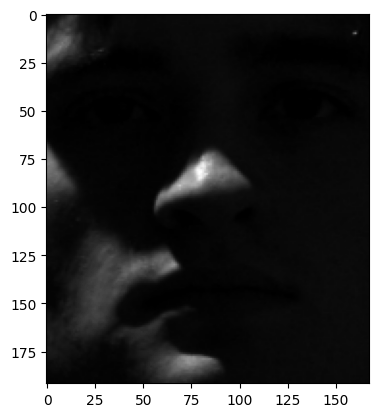

In [11]:
# one sample of dataset
plt.imshow(Image.fromarray(X[0].reshape(standard_size)), cmap='gray');

We want to use PCA for dimensionality reduction, so first let's normalize our data:

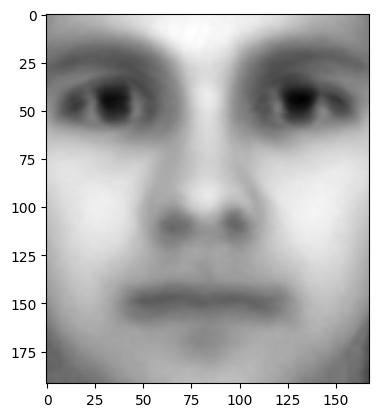

In [29]:
#############################################
#   normalize X and show the mean picture   #
#               Your Code                   #
#############################################
X_normal = (X - np.mean(X)) / np.std(X)

mean_image = np.mean(X_normal, axis=0)
plt.imshow(mean_image.reshape(standard_size), cmap='gray')
plt.show()

Now run the PCA model on normalized data: (read [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for PCA)

In [30]:
pca = PCA()
p_components = pca.fit_transform(X_normal)

len(p_components)

2424

We need to decide on the number of PCA components to use. This is a hyperparameter and Later we might want to use a grid search to tune it. However here to have a better intuition for the range of our search and choose a candidate we can plot the graph of explained variance ratio of different components. You can find these values in `explained_variance_ratio_` attribute of your PCA object.

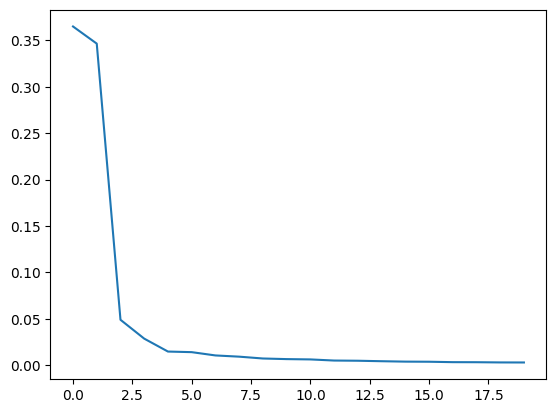

In [31]:
x = list(range(20))
#################################################################
#   plot the explained variance ratio of first 20 components    #
#                          Your Code                            #
#################################################################
plt.plot(x, pca.explained_variance_ratio_[:20])

You can decide on the number of components to use by examining the above graph. Where the graph gets flat or you see an elbow is a good candidate.

In [32]:
# fill below variable with your predicted number of components
predicted_pca_components = 6 #or maybe 5

To get a better sense of your data it is valuable to show your PCA components. You can find components in `components_` attribute of your PCA object. Select `2 * predicted_pca_components` first number of them and plot them.

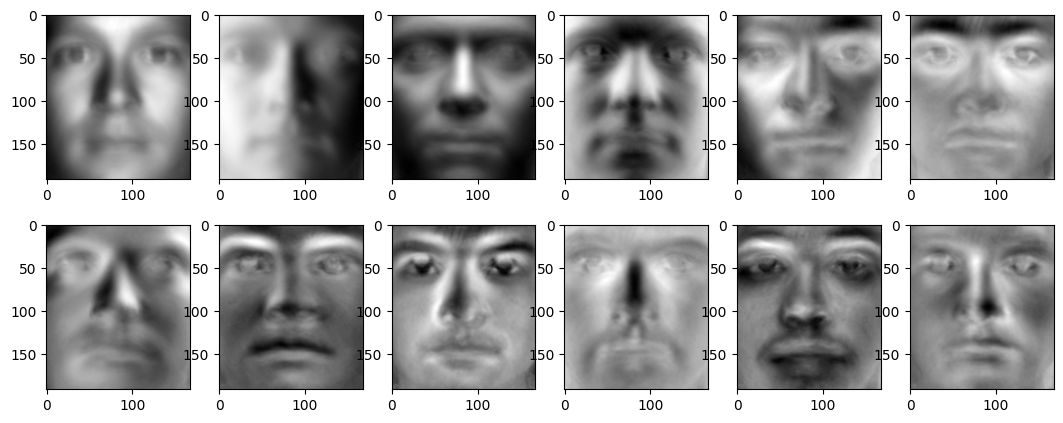

In [44]:
#############################
#   plot your eigen faces   #
#         Your Code         #
#############################
nums = 2 * predicted_pca_components
components = pca.components_[:nums]
fig, axes = plt.subplots(nrows=2, ncols=predicted_pca_components, figsize=(13, 5))
for i, a in enumerate(axes.flat):
    a.imshow(components[i].reshape(standard_size), cmap='gray')
plt.show()

Now you need to project all data on the space of PCA components. If $X$ is our data and $E$ is the matrix of PCA components, then the projection of $X$ on the space spanned by $E$ will be $X\cdot E^T$.

In [45]:
################################################
#   project X on the space of pca components   #
#                  Your Code                   #
###############################################
X_projected = np.dot(X_normal, pca.components_.T)

### 2.3 Train and Test Model on the Entier Features (10 Points)

Now you have reduced the dimensionality of your data and you can train a decision tree on these features. But first let's train a decision tree on the entire features.

In [49]:
#########################################################
#   split your entier data (X) into train test splits   #
#                    Your Code                          #
#########################################################
X_train, X_test, y_train, y_test = train_test_split(X_normal, y, test_size=0.2, random_state=44)

In [50]:
###########################################################################
#   train a decision tree classifier on entire features of training set   #
#                               Your Code                                 #
###########################################################################
full_dt = DecisionTreeClassifier()
full_dt = full_dt.fit(X_train, y_train)

Let's evaluate this model:

In [54]:
###############################################################################
#   report accuracy, confusion matrix, number of nodes, max depth of your DT  #
#                               Your Code                                     #
###############################################################################
from sklearn.metrics import confusion_matrix
evaluating =  full_dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, evaluating))
confusion_mat = confusion_matrix(y_test, evaluating)
print("Confusion:", confusion_mat)
num_nodes = full_dt.tree_.node_count
print("Nodes:", num_nodes)
max_depth = full_dt.tree_.max_depth
print("Max_depth:", max_depth)

Accuracy: 0.7628865979381443
Confusion: [[13  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  1  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  1  0 ...  0  3  0]
 [ 0  0  0 ...  0  0  9]]
Nodes: 467
Max_depth: 47


### 2.4 Train and Test model on the Reduced Features (10 Points)

Now use reduced features to train your decision tree classifer.

In [55]:
#####################################################
#   split your reduce data into train test splits   #
#                   Your Code                       #
#####################################################
X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.2, random_state=44)

In [56]:
############################################################################
#   train a decision tree classifier on reduced features of training set   #
#                               Your Code                                  #
############################################################################
reduced = DecisionTreeClassifier()
reduced = reduced.fit(X_train, y_train)

Report evaluation of decision tree trained on reduce data:

In [57]:
###############################################################################
#   report accuracy, confusion matrix, number of nodes, max depth of your DT  #
#                               Your Code                                     #
###############################################################################
evaluating =  reduced.predict(X_test)
print("Accuracy:", accuracy_score(y_test, evaluating))
confusion_mat_reduced = confusion_matrix(y_test, evaluating)
print(confusion_mat_reduced)
num_nodes = reduced.tree_.node_count
print(num_nodes)
max_depth2 = reduced.tree_.max_depth
print(max_depth2)

Accuracy: 0.44123711340206184
[[7 0 0 ... 0 0 0]
 [0 4 0 ... 1 0 0]
 [1 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 7 1 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 1]]
1125
49


### 2.5 Hyperparameter Tuning (10 Points + 10 Optional)

If you did everything right, you would see that the accuracy of the decision tree trained on reduced data is not even close to the previous one using the entire features. Now try to tune hyperparameters `max_depth` and `number_of_pca_components` (optional) to get close to the previous model or even perform better than that. You need to perform a grid search on the value of these parameters and use cross-validation to choose the best ones. (read [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for sklearn grid search module)

In [58]:
#######################################################################################
#   tune hyperparameters `max_depth` and `pca_n_components` using grid search and cv  #
#                                     Your Code                                       #
#######################################################################################
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('pca', PCA()),
    ('dt', RandomForestClassifier())
])

param_grid = {
    'dt__max_depth': list(range(1,50,5)),
    'pca__n_components': list(range(1,20))
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X_projected, y, test_size=0.2, random_state=44)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [60]:
#####################################################################################
#   report accuracy, confusion matrix, number of nodes, max depth of your tuned DT  #
#                                   Your Code                                       #
#####################################################################################
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test , y_pred)
print("Accuracy:", accuracy)
confusion_mat =confusion_matrix(y_test , y_pred)
print("Confusion Matrix:", confusion_mat)
num_nodes = best_model.named_steps['dt'].estimators_[0].tree_.node_count
print("Nodes:", num_nodes)
max_depth = best_model.named_steps['dt'].estimators_[0].tree_.max_depth
print("Max depth:", max_depth)
print(grid_search.best_score_)

Accuracy: 0.8061855670103093
Confusion Matrix: [[11  0  1 ...  0  1  0]
 [ 0 10  0 ...  0  1  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  9  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  1  7]]
Nodes: 1033
Max depth: 26
0.7725765204187645
